In [1]:
import csv, os ; from glob import glob
import fnmatch
import math
import numpy as np ; import pandas as pd
from scipy.signal import butter, filtfilt
import xlsxwriter
from matplotlib import pyplot as plt
from pykalman import KalmanFilter
from scipy import stats
import pywt
from skimage.restoration import denoise_wavelet
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm ; import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
train_test_set = sorted(glob('GNB/100_new/*.csv'))
validation_set = sorted(glob('GNB/35_new/*.csv'))
df_98_temp     = pd.DataFrame()
df_35_temp     = pd.DataFrame()

category = 0
for i,file in enumerate(train_test_set):
    user_df_98 = pd.read_csv(file)
    user_df_98 = user_df_98[user_df_98.columns[:22]][:]
    
    lst_730   = user_df_98.columns[1:8].tolist()
    lst_850   = user_df_98.columns[8:15].tolist()
    lst_back = user_df_98.columns[15:22].tolist()
    for idx in range(7):
        user_df_98[lst_730[idx]] = user_df_98[lst_730[idx]] - np.mean(user_df_98[lst_730[idx]]) #  DC OFFSET 제거
        user_df_98[lst_850[idx]] = user_df_98[lst_850[idx]] - np.mean(user_df_98[lst_850[idx]]) #  DC OFFSET 제거
        user_df_98[lst_730[idx]] = user_df_98[lst_730[idx]] + user_df_98[lst_back[idx]] + 1300
        user_df_98[lst_850[idx]] = user_df_98[lst_850[idx]] + user_df_98[lst_back[idx]] + 1300
    user_df_98 = user_df_98[user_df_98.columns[:15]][:]
    user_id    = int(file.split('/')[-1].split('\\')[1].split(".")[0])
    user_df_98.insert(0,'uid',user_id)
    if i<55:
        category='CN'
    elif 55<=i<=85:
        category='MCI'
    elif 85<=i<=99:
        category='AD'
    user_df_98['Category'] = category
    df_98_temp             = pd.concat([df_98_temp,user_df_98])
    
uid_lst = list(df_98_temp.uid.unique().tolist())
df_98   = pd.DataFrame()
for i in uid_lst:
    df    = df_98_temp[df_98_temp.uid==i]
    df_98 = pd.concat([df_98,df])
df_98 = df_98.reset_index(drop=True)
del df_98_temp

for i, file in enumerate(validation_set):
    user_df_35 = pd.read_csv(file)
    user_df_35 = user_df_35[user_df_35.columns[:22]][:]

    lst_730  = user_df_35.columns[1:8].tolist()
    lst_850  = user_df_35.columns[8:15].tolist()
    lst_back = user_df_35.columns[15:22].tolist()

    for idx in range(7) :
        user_df_35[lst_730[idx]] = user_df_35[lst_730[idx]] - np.mean(user_df_35[lst_730[idx]]) #  DC OFFSET 제거
        user_df_35[lst_850[idx]] = user_df_35[lst_850[idx]] - np.mean(user_df_35[lst_850[idx]]) #  DC OFFSET 제거
        user_df_35[lst_730[idx]] = user_df_35[lst_730[idx]] + user_df_35[lst_back[idx]] + 200
        user_df_35[lst_850[idx]] = user_df_35[lst_850[idx]] + user_df_35[lst_back[idx]] + 200
    user_df_35 = user_df_35[user_df_35.columns[:15]][:]
    uid        = int(file.split('.')[0].split('/')[-1].split('\\')[-1])
    user_df_35.insert(0,'uid', uid)
    if i<=5:
        category = 'AD'
    elif 6<=i<=21:
        category = 'CN'
    elif 22<=i<=36:
        category = "MCI"
    user_df_35['Category'] = category
    df_35_temp = pd.concat([df_35_temp,user_df_35])

uid_lst = list(set(df_35_temp.uid.unique().tolist()))
df_35   = pd.DataFrame()
for uid in uid_lst :
    df    = df_35_temp[df_35_temp.uid==uid]
    df_35 = pd.concat([df_35,df])

df_35 = df_35.reset_index(drop = True)
del df_35_temp
def all_section_slice_data(df, ss_1,es_1,ss_2,es_2,ss_3,es_3,ss_4,es_4,ss_5,es_5) :
    user_lst = df.uid.unique()
    new_df   = pd.DataFrame()
    for i in user_lst:
        slice_df = pd.concat([df[df.uid==i][ss_1:es_1],df[df.uid==i][ss_2:es_2],df[df.uid==i][ss_3:es_3]
                              ,df[df.uid==i][ss_4:es_4],df[df.uid==i][ss_5:es_5]])
        new_df   = pd.concat([new_df,slice_df])
    return new_df

ss_1,es_1,ss_2,es_2,ss_3,es_3,ss_4,es_4,ss_5,es_5 = 0,1000,1400,2000,2400,3000,3400,4000,4400,5000
df_35 = all_section_slice_data(df_35,
                               ss_1,es_1,ss_2,es_2,ss_3,es_3,ss_4,es_4,ss_5,es_5).reset_index(drop=True)

In [3]:
df_98

,uid,Index,A_730_0,A_730_1,A_730_2,A_730_3,A_730_4,A_730_5,A_730_6,A_850_0,A_850_1,A_850_2,A_850_3,A_850_4,A_850_5,A_850_6,Category
0,1,1,1311.496367,1273.438826,1238.495495,1260.062191,1299.603022,1269.898867,1021.201686,1339.898285,1321.858762,1325.773322,1327.972682,1344.498402,1312.812845,1357.996222,CN
1,1,2,1340.496367,1320.438826,1327.495495,1315.062191,1332.603022,1333.898867,1350.201686,1348.898285,1324.858762,1348.773322,1322.972682,1352.498402,1337.812845,1356.996222,CN
2,1,3,1335.496367,1318.438826,1322.495495,1316.062191,1352.603022,1322.898867,1353.201686,1334.898285,1324.858762,1306.773322,1307.972682,1316.498402,1312.812845,1359.996222,CN
3,1,4,1341.496367,1325.438826,1321.495495,1313.062191,1341.603022,1328.898867,1350.201686,1347.898285,1341.858762,1344.773322,1347.972682,1354.498402,1318.812845,1351.996222,CN
4,1,5,1330.496367,1323.438826,1323.495495,1314.062191,1331.603022,1331.898867,1357.201686,1359.898285,1355.858762,1328.773322,1342.972682,1351.498402,1288.812845,1360.996222,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337216,99,3437,1325.316187,1301.100843,1318.746004,1316.963673,1318.907294,1322.256030,1369.448416,1318.786399,1308.441732,1317.173205,1322.898867,1323.819820,1306.579192,1364.822726,AD
337217,99,3438,1329.316187,1318.100843,1319.746004,1322.963673,1336.907294,1299.256030,1355.448416,1322.786399,1330.441732,1321.173205,1316.898867,1330.819820,1314.579192,1353.822726,AD
337218,99,3439,1309.316187,1304.100843,1312.746004,1304.963673,1305.907294,1322.256030,1351.448416,1309.786399,1316.441732,1319.173205,1313.898867,1317.819820,1307.579192,1354.822726,AD
337219,99,3440,1317.316187,1309.100843,1325.746004,1309.963673,1321.907294,1319.256030,1353.448416,1318.786399,1310.441732,1316.173205,1317.898867,1315.819820,1315.579192,1350.822726,AD


In [4]:
df_35

,uid,Index,A_730_0,A_730_1,A_730_2,A_730_3,A_730_4,A_730_5,A_730_6,A_850_0,A_850_1,A_850_2,A_850_3,A_850_4,A_850_5,A_850_6,Category
0,1,0,278.253392,270.383684,258.654406,262.505834,257.039323,262.849233,265.730931,274.067656,275.699070,285.007746,266.680852,258.957125,296.289409,311.907872,AD
1,1,1,277.503392,270.071184,259.154406,262.193334,256.914323,262.724233,265.730931,270.317656,274.886570,285.570246,266.055852,258.832125,295.601909,312.095372,AD
2,1,2,277.003392,270.196184,259.591906,262.130834,257.726823,262.661733,266.043431,271.442656,275.011570,286.070246,266.118352,259.019625,295.601909,311.532872,AD
3,1,3,278.503392,270.571184,260.029406,262.505834,257.664323,263.099233,266.230931,271.192656,275.386570,286.632746,266.305852,259.144625,296.226909,311.595372,AD
4,1,4,285.503392,271.196184,260.404406,262.880834,258.351823,263.786733,265.918431,274.130156,276.074070,287.320246,266.680852,259.394625,297.039409,311.720372,AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129195,351,4995,218.631722,210.944099,193.439202,216.168406,219.381611,245.473715,307.388963,218.309342,209.213946,204.714895,214.457606,218.617019,189.370535,349.933615,MCI
129196,351,4996,218.756722,211.006599,193.876702,216.418406,219.569111,246.036215,308.326463,218.371842,209.338946,204.652395,214.832606,218.804519,189.870535,351.308615,MCI
129197,351,4997,218.819222,211.194099,194.251702,216.605906,219.756611,246.473715,308.263963,218.621842,209.776446,206.527395,215.207606,219.054519,190.683035,352.121115,MCI
129198,351,4998,218.694222,211.194099,193.939202,216.543406,219.694111,246.223715,308.326463,218.684342,209.901446,206.402395,215.332606,219.117019,190.870535,351.433615,MCI


In [5]:
def lowpassfilter(signal, thresh = 0, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    if len(signal) != len(reconstructed_signal) :
        reconstructed_signal = reconstructed_signal[1:]

    return reconstructed_signal[:]

In [6]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = 2 * cutoff/fs
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b,a,data)
    return y

In [ ]:
# wav_df = pd.DataFrame()

# for idx in tqdm(df_98.uid.unique()) :

#     uid_1 = df_98[df_98.uid==idx]
#     col_lst = uid_1.columns[2:-1].tolist()

#     for j in col_lst :
#         uid_1[j] = lowpassfilter(uid_1[j].values, 0.27)

#     wav_df = pd.concat([wav_df,uid_1])

# wav_df.head()

In [7]:
wav_df_98 = pd.DataFrame()

for idx in tqdm(df_98.uid.unique()) :

    uid_1 = df_98[df_98.uid==idx]
    col_lst = uid_1.columns[2:-1].tolist()

    for j in col_lst :
        uid_1[j] = gaussian_filter1d(uid_1[j].values, 3)
    wav_df_98 = pd.concat([wav_df_98,uid_1])

wav_df_98.head()

  0%|          | 0/98 [00:00<?, ?it/s]

,uid,Index,A_730_0,A_730_1,A_730_2,A_730_3,A_730_4,A_730_5,A_730_6,A_850_0,A_850_1,A_850_2,A_850_3,A_850_4,A_850_5,A_850_6,Category
0,1,1,1331.010253,1309.502723,1303.070151,1301.506005,1329.619508,1314.463960,1266.283925,1343.200125,1329.315102,1331.178923,1326.076014,1341.783367,1319.514727,1357.615118,CN
1,1,2,1331.585533,1311.023634,1305.559615,1303.170321,1330.640880,1316.145748,1275.062493,1343.080075,1329.800702,1331.192642,1326.172865,1341.609795,1319.542798,1357.582476,CN
2,1,3,1332.558672,1313.633082,1309.830086,1306.026779,1332.354238,1319.018100,1289.986272,1342.762625,1330.492297,1331.178421,1326.226661,1341.310902,1319.734774,1357.490230,CN
3,1,4,1333.663753,1316.658978,1314.771745,1309.336191,1334.267681,1322.313591,1307.044491,1342.150250,1330.978611,1331.065088,1326.051509,1340.965012,1320.281132,1357.285466,CN
4,1,5,1334.665557,1319.458393,1319.308263,1312.389010,1335.948918,1325.291092,1322.553948,1341.202026,1330.924009,1330.772491,1325.533449,1340.644531,1321.317128,1356.904093,CN


In [8]:
wav_df_35 = pd.DataFrame()

for idx in tqdm(df_35.uid.unique()) :

    uid_2 = df_35[df_35.uid==idx]
    col_lst2 = uid_2.columns[2:-1].tolist()

    for j in col_lst2 :
        uid_2[j] = gaussian_filter1d(uid_2[j].values, 3)
    wav_df_35 = pd.concat([wav_df_35,uid_2])

wav_df_35.head()

  0%|          | 0/38 [00:00<?, ?it/s]

,uid,Index,A_730_0,A_730_1,A_730_2,A_730_3,A_730_4,A_730_5,A_730_6,A_850_0,A_850_1,A_850_2,A_850_3,A_850_4,A_850_5,A_850_6,Category
0,1,0,279.684494,270.487205,259.443408,262.464006,257.420222,262.980021,265.825005,272.799367,275.468504,286.023851,266.435675,259.065522,296.165045,311.714312,AD
1,1,1,280.148320,270.535822,259.500692,262.493012,257.456755,263.006145,265.806517,273.020794,275.516394,286.124557,266.463268,259.091503,296.212730,311.666443,AD
2,1,2,280.963040,270.617239,259.592151,262.540558,257.512665,263.038605,265.765145,273.428481,275.599128,286.295277,266.511052,259.135279,296.287857,311.573734,AD
3,1,3,281.903978,270.701040,259.678910,262.585671,257.559292,263.040910,265.695483,273.936836,275.689193,286.481757,266.562008,259.181424,296.350582,311.442293,AD
4,1,4,282.659539,270.746684,259.718543,262.598917,257.565867,262.967501,265.595816,274.400620,275.745762,286.619271,266.588436,259.209817,296.346470,311.281218,AD


In [9]:
new_df_98 = pd.DataFrame()

for idx in tqdm(wav_df_98.uid.unique()) :

    uid_1 = wav_df_98[wav_df_98.uid==idx]
    uid1 = uid_1[uid_1.columns[2:-1]]
    intensities = uid1
    means      = np.mean(np.absolute(intensities), axis = 1)
    means      = np.expand_dims(means, axis = 1)
    delta_od   = -np.log10(np.absolute(intensities)/means)
    lst_730  = delta_od.columns[:7].tolist()
    lst_850  = delta_od.columns[7:].tolist()

    hb_df  = pd.DataFrame()

    for i in range(len(lst_730)) :

        red_mes_data = np.reshape(
            delta_od[lst_730[i]].values, (delta_od[lst_730[i]].values.shape[0], 1))
        ir_mes_data = np.reshape(
            delta_od[lst_850[i]].values, (delta_od[lst_850[i]].values.shape[0], 1))
        mes_data_shape = ir_mes_data.shape

        oxy_red = 2.1838
        oxy_ir = 7.0146*1.355
        dxy_red = 10.2470
        dxy_ir = 6.8501*1.355

        mean_baseline_red = np.mean(red_mes_data[0:100])
        mean_baseline_ir = np.mean(ir_mes_data[0:100])

        pos = np.where(
            red_mes_data*mean_baseline_red > 0)

        a_red = np.array([
                math.log(mean_baseline_red/i[0]) if idx in pos[0] else 0 \
                for idx, i in enumerate(red_mes_data)
            ])
        pos = np.where(
            ir_mes_data*mean_baseline_ir > 0
            )
        a_ir = np.array([
                math.log(mean_baseline_ir/i[0]) if idx in pos[0] else 0 \
                for idx, i in enumerate(ir_mes_data)
            ])

        hb = np.zeros(mes_data_shape)
        hbo = np.zeros(mes_data_shape)
        hbt = np.zeros(mes_data_shape)

        ####### Oxy Hb #######
        if ((oxy_red*dxy_ir - oxy_ir*dxy_red)!=0):
            hbo = (a_red*dxy_ir - a_ir*dxy_red)/(oxy_red*dxy_ir - oxy_ir*dxy_red)

        ####### DeOxy Hb #######
        if ((dxy_red*oxy_ir - dxy_ir*oxy_red)!=0):
            hb = (a_red*oxy_ir - a_ir*oxy_red)/(dxy_red*oxy_ir - dxy_ir*oxy_red)
            # hbr 과 같은의미

        hbt = hb+hbo

        ch_name = str(int(lst_730[i].split('_')[-1]) +1)

        hb_df['hbo_'+ ch_name] = hbo
        hb_df['hbr_'+ ch_name] = hb
        hb_df['hbt_'+ ch_name] = hbt
#     hb_df[['hbo_1','hbo_2','hbo_3','hbo_4','hbo_5','hbo_'
#           ,'hbo_1']].plot(figsize=(15, 6),title="유저 {} ".format(idx))

    hb_df.insert(0,'uid',idx)
    hb_df.insert(22, 'label', uid_1.Category.unique()[0] )

    new_df_98 = pd.concat([new_df_98,hb_df])

  0%|          | 0/98 [00:00<?, ?it/s]

In [10]:
new_df_35 = pd.DataFrame()

for idx in tqdm(wav_df_35.uid.unique()) :

    uid_2 = wav_df_35[wav_df_35.uid==idx]
    uid2 = uid_2[uid_2.columns[2:-1]]
    intensities = uid2
    means      = np.mean(np.absolute(intensities), axis = 1)
    means      = np.expand_dims(means, axis = 1)
    delta_od   = -np.log10(np.absolute(intensities)/means)
    lst_730  = delta_od.columns[:7].tolist()
    lst_850  = delta_od.columns[7:].tolist()

    hb_df  = pd.DataFrame()

    for i in range(len(lst_730)) :

        red_mes_data = np.reshape(
            delta_od[lst_730[i]].values, (delta_od[lst_730[i]].values.shape[0], 1))
        ir_mes_data = np.reshape(
            delta_od[lst_850[i]].values, (delta_od[lst_850[i]].values.shape[0], 1))
        mes_data_shape = ir_mes_data.shape

        oxy_red = 2.1838
        oxy_ir = 7.0146*1.355
        dxy_red = 10.2470
        dxy_ir = 6.8501*1.355

        mean_baseline_red = np.mean(red_mes_data[0:100])
        mean_baseline_ir = np.mean(ir_mes_data[0:100])

        pos = np.where(
            red_mes_data*mean_baseline_red > 0)

        a_red = np.array([
                math.log(mean_baseline_red/i[0]) if idx in pos[0] else 0 \
                for idx, i in enumerate(red_mes_data)
            ])
        pos = np.where(
            ir_mes_data*mean_baseline_ir > 0
            )
        a_ir = np.array([
                math.log(mean_baseline_ir/i[0]) if idx in pos[0] else 0 \
                for idx, i in enumerate(ir_mes_data)
            ])

        hb = np.zeros(mes_data_shape)
        hbo = np.zeros(mes_data_shape)
        hbt = np.zeros(mes_data_shape)

        ####### Oxy Hb #######
        if ((oxy_red*dxy_ir - oxy_ir*dxy_red)!=0):
            hbo = (a_red*dxy_ir - a_ir*dxy_red)/(oxy_red*dxy_ir - oxy_ir*dxy_red)

        ####### DeOxy Hb #######
        if ((dxy_red*oxy_ir - dxy_ir*oxy_red)!=0):
            hb = (a_red*oxy_ir - a_ir*oxy_red)/(dxy_red*oxy_ir - dxy_ir*oxy_red)
            # hbr 과 같은의미

        hbt = hb+hbo

        ch_name = str(int(lst_730[i].split('_')[-1]) +1)

        hb_df['hbo_'+ ch_name] = hbo
        hb_df['hbr_'+ ch_name] = hb
        hb_df['hbt_'+ ch_name] = hbt
#     hb_df[['hbo_1','hbo_2','hbo_3','hbo_4','hbo_5','hbo_'
#           ,'hbo_1']].plot(figsize=(15, 6),title="유저 {} ".format(idx))

    hb_df.insert(0,'uid',idx)
    hb_df.insert(22, 'label', uid_2.Category.unique()[0] )

    new_df_35 = pd.concat([new_df_35,hb_df])

  0%|          | 0/38 [00:00<?, ?it/s]

<Axes: >

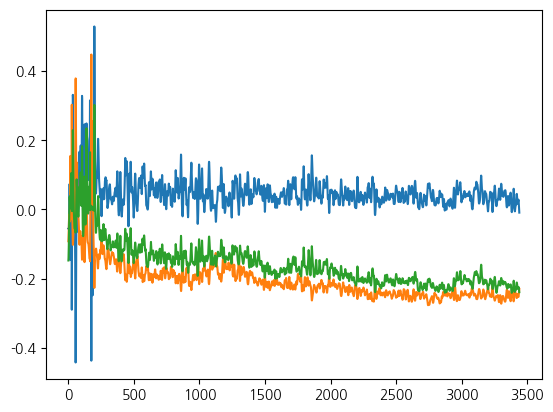

In [11]:
new_df_98[new_df_98.uid==1].hbo_1.plot()
new_df_98[new_df_98.uid==1].hbr_1.plot()
new_df_98[new_df_98.uid==1].hbt_1.plot()

In [12]:
# new_df_98.to_csv('train_dcoffset_scale_gaussian.csv')
# new_df_35.to_csv('test_dcoffset_scale_gaussian.csv')